___


# <font color= #8A0829> Proyecto Taller de Modelado de Datos </font>

<Strong> Alumnos: </Strong>
- Marcela Quintero Pérez
- Santiago Ayon Sanchez
- Gael Rendon Mendoza

<Strong> Año </Strong>: 2025

<Strong> Email: </Strong>  
- <font color="blue"> is717644@iteso.mx </font>
- <font color="blue"> santiago.ayon@iteso.mx </font>
- <font color="blue"> gael.rendon@iteso.mx </font>

___

## Librerías

In [125]:
# Librerías
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.colors as pc
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from lightgbm import LGBMRegressor

from plotly.subplots import make_subplots

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, learning_curve

# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

colors = pc.qualitative.Plotly + pc.qualitative.D3

sns.set_theme(style="whitegrid")

seed = 123

## Regresión

###  <font color= #ffffffff> Health Insurance </font>
url: https://www.kaggle.com/datasets/awaiskaggler/insurance-csv

Este dataset contiene información de asegurados de seguros médicos en Estados Unidos, con un total de 7 variables por registro. Cada registro corresponde a un asegurado e incluye datos demográficos y de estilo de vida, como edad (age), sexo (sex), índice de masa corporal (bmi), número de hijos (children), tabaquismo (smoker) y región geográfica (region). Además, se registra el costo total de los gastos médicos (charges) de cada asegurado.

El problema se abordará como una tarea de regresión, cuyo objetivo es predecir los gastos médicos (charges) a partir de las características personales, médicas y de estilo de vida del asegurado. Esta predicción es útil para estimar el riesgo individual y determinar primas de seguro ajustadas a cada perfil de asegurado.

### Descripción de las variables del dataset

- **age**: Edad del beneficiario pricipal.
- **sex**: Generdo del asegurado. Valores: `male` o `female`.
- **bmi**: Indice de masa corporal, que proporciona una comprensión del peso corporal relativo a la altura (kg/m²).
- **children**: Número de hijos cubiertos por el seguro médico / Número de dependientes.
- **smoker**: Indicador de si el asegurado fuma. Valores: `yes` o `no`.
- **region**: Región residencial del beneficiario en EE. UU. Valores: `northeast`, `southeast`, `southwest`, `northwest`.
- **charges**: Costos médicos individuales facturados por la asegurados. (Variable objetivo).

In [126]:
# fetch dataset 
df_regresion = pd.read_csv('insurance.csv')
X = df_regresion.drop(columns='charges')
y = df_regresion['charges']

### EDA

In [127]:
df_regresion.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


El conjunto de datos por analizar cuenta con 7 variables y 1338 observaciones.

In [128]:
# Exploración inicial del dataset
print("Dimensiones del dataset:", df_regresion.shape)

print("\nInfo del dataset:")
print(df_regresion.info())

Dimensiones del dataset: (1338, 7)

Info del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


El dataset no cuenta con valores nulos, así mismo, solo contiene un registro duplicado que procederá a ser eliminado.

In [129]:
# Revisar valores nulos y duplicados
print("\nValores nulos por columna:")
print(df_regresion.isnull().sum())

print("\nNúmero de registros duplicados:", df_regresion.duplicated().sum())
df_regresion = df_regresion.drop_duplicates()


Valores nulos por columna:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Número de registros duplicados: 1


In [130]:
print("\nEstadísticas descriptivas:")
print(df_regresion.describe().T)


Estadísticas descriptivas:
           count          mean           std        min       25%        50%  \
age       1337.0     39.222139     14.044333    18.0000    27.000    39.0000   
bmi       1337.0     30.663452      6.100468    15.9600    26.290    30.4000   
children  1337.0      1.095737      1.205571     0.0000     0.000     1.0000   
charges   1337.0  13279.121487  12110.359656  1121.8739  4746.344  9386.1613   

                  75%          max  
age          51.00000     64.00000  
bmi          34.70000     53.13000  
children      2.00000      5.00000  
charges   16657.71745  63770.42801  


Para las columnas categóricas del conjunto de datos se procederá a convertirlas al tipo de dato category con el fin de optimizar su almacenamiento y facilitar su tratamiento durante el análisis exploratorio y el modelado. Esta conversión permitirá manejar estas variables de manera más adecuada, diferenciando explícitamente los valores categóricos sin modificar aún su codificación.

In [131]:
cat_cols = ['sex', 'smoker', 'region']

for col in cat_cols:
    df_regresion[col] = df_regresion[col].astype('category')

In [132]:
# Exploración inicial del dataset
print("Dimensiones del dataset:", df_regresion.shape)

print("\nInfo del dataset:")
print(df_regresion.info())

Dimensiones del dataset: (1337, 7)

Info del dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1337 non-null   int64   
 1   sex       1337 non-null   category
 2   bmi       1337 non-null   float64 
 3   children  1337 non-null   int64   
 4   smoker    1337 non-null   category
 5   region    1337 non-null   category
 6   charges   1337 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 56.6 KB
None


In [133]:
categorical_cols = df_regresion.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df_regresion.select_dtypes(include=['float64', 'int64']).columns.tolist()

numerical_cols.remove('charges')

Veamos como es la distribucion de la variable `charges`

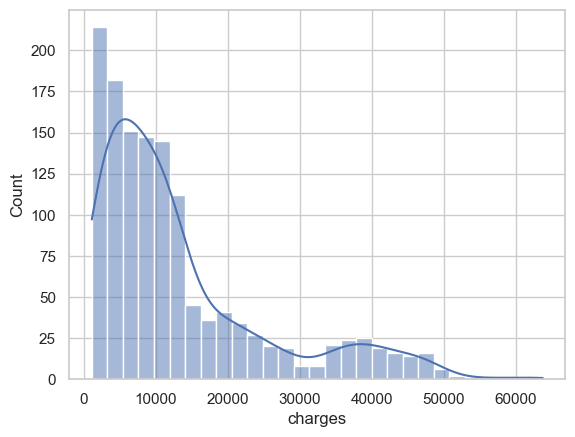

In [134]:
sns.histplot(df_regresion, x='charges', kde=True);

Para las variables numéricas, se procede a analizar su comportamiento respecto al target `charges`:

In [135]:
for i, var in enumerate(numerical_cols):
    color = colors[i % len(colors)]

    fig = make_subplots(rows=1, cols=2, subplot_titles=(f"{var} vs charges", f"Distribución de {var}"))

    scatter = go.Scatter(x=df_regresion[var], y=df_regresion["charges"], mode="markers", marker=dict(color=color, opacity=0.6), name=f"{var} vs charges")
    fig.add_trace(scatter, row=1, col=1)

    hist = go.Histogram(x=df_regresion[var], marker_color=color, name=f"Distribución de {var}")
    fig.add_trace(hist, row=1, col=2)

    fig.update_layout(title_text=f"Análisis de {var}", title_font=dict(size=20, family="Arial", color="black"), title_x=0.5, showlegend=False)

    fig.show()

En los gráficos anteriores se pudo observar lo siguiente:

- **Age:**
    - La distribución de edad se concentra entre aproximadamente 20 y 60 años, con mayor densidad en los grupos intermedios.
    - A mayor edad, las tarifas tienden a aumentar, aunque con mucha dispersión.
    - La edad tiene una relación positiva moderada con los costos médicos; podría ser una variable relevante para el modelo.

- **BMI:**
    - El BMI se distribuye principalmente entre 20 y 40, con una forma aproximadamente normal centrada en los valores cercanos a 30.
    - En el gráfico de dispersión se observan algunos outliers de BMI elevado con costos altos, posiblemente asociados a condiciones de salud complejas.
    - Hay una dispersión considerable, con muchos individuos compartiendo BMI similares pero con costos muy variados.
    - El BMI por sí solo no tiene una relación fuerte con los costos, pero los valores altos podrían tener efectos importantes

- **Children:**
    - La mayoría de los registros tiene 0 a 2 hijos, siendo 0 el valor más frecuente.
    - Los valores de 3 a 5 hijos tienen poca representación, lo que podría limitar su utilidad predictiva.
    - Probablemente tenga baja relevancia en el modelo a menos que interactúe con otras variables sociodemográficas.

Las variables numéricas muestran comportamientos diferenciados respecto a los costos médicos. `Age` presenta una relación ascendente moderada con los cargos, lo que sugiere un aporte predictivo relevante, especialmente al capturar efectos asociados al envejecimiento. El `BMI`, aunque disperso, muestra que valores elevados pueden asociarse a mayores costos, por lo que podría aportar valor al modelo en presencia de interacciones o al analizar extremos. En contraste, el número de hijos no muestra una relación clara con los cargos, por lo que probablemente tenga un impacto predictivo bajo. En conjunto, age y bmi destacan como las variables numéricas con mayor potencial explicativo.

Ahora se procede a analizar el comportamiento de las variables categóricas respecto al target `charges`:

In [136]:
for i, col in enumerate(categorical_cols):
    color = colors[i % len(colors)]

    counts = df_regresion[col].value_counts().reset_index()
    counts.columns = [col, "count"]

    fig = make_subplots(rows=1, cols=2, subplot_titles=(f"{col} vs charges", f"Frecuencia de {col}"))

    fig_box = px.box(df_regresion, x=col, y="charges", points="all", color_discrete_sequence=[color])
    for trace in fig_box.data: fig.add_trace(trace, row=1, col=1)

    fig_count = px.bar(counts, x=col, y="count", text="count", color_discrete_sequence=[color])
    for trace in fig_count.data:
        fig.add_trace(trace, row=1, col=2)

    fig.update_layout(title_text=f"Análisis de {col}", title_font=dict(size=20, family="Arial", color="black"), title_x=0.5, showlegend=False)

    fig.show()

En los gráficos anteriores se pudo observar lo siguiente:

- **Sex:** 
    - La distribución está prácticamente balanceada: 50.48% hombres y 49.51% mujeres.
    - La variable está bien equilibrada; no se requiere tratamiento adicional. Puede utilizarse directamente como variable categórica en el modelado.

- **Smoker:** 
    - Existe un desbalance claro: 79.5% no fumadores y 20.5% fumadores.
    - La categoría yes (fumadores) es minoritaria, pero suele tener un impacto notable en los costos médicos.
    - Aunque es una variable binaria, el desbalance sugiere que los fumadores podrían tener un efecto fuerte y diferenciado en los cargos.

- **Region:** 
    - Las cuatro regiones están muy equilibradas, con proporciones cercanas entre sí.
    - La región southeast es ligeramente más representada (27.22%), mientras que las demás rondan el 24.2%.
    - La distribución regional es bastante uniforme, por lo que la variable aporta segmentación geográfica sin desbalance. Puede ser útil para capturar diferencias en costos por zona.   

Entre las variables categóricas, `smoker` sobresale claramente como la mejor predictora potencial, debido a su conocida y marcada influencia en los costos médicos, aun cuando la categoría de fumadores sea minoritaria. Por otro lado, `sex` presenta una distribución muy balanceada y su efecto suele ser más débil, por lo que probablemente contribuya menos al modelo. `Region` muestra una distribución casi uniforme, y aunque puede capturar diferencias geográficas, su influencia suele ser moderada. En conjunto, smoker es la variable categórica más poderosa para un modelo de regresión, mientras que sex y region actuarían más como variables complementarias.

Asi que vamos a observar a `smoker` como se comporta frente a las variables numericas.

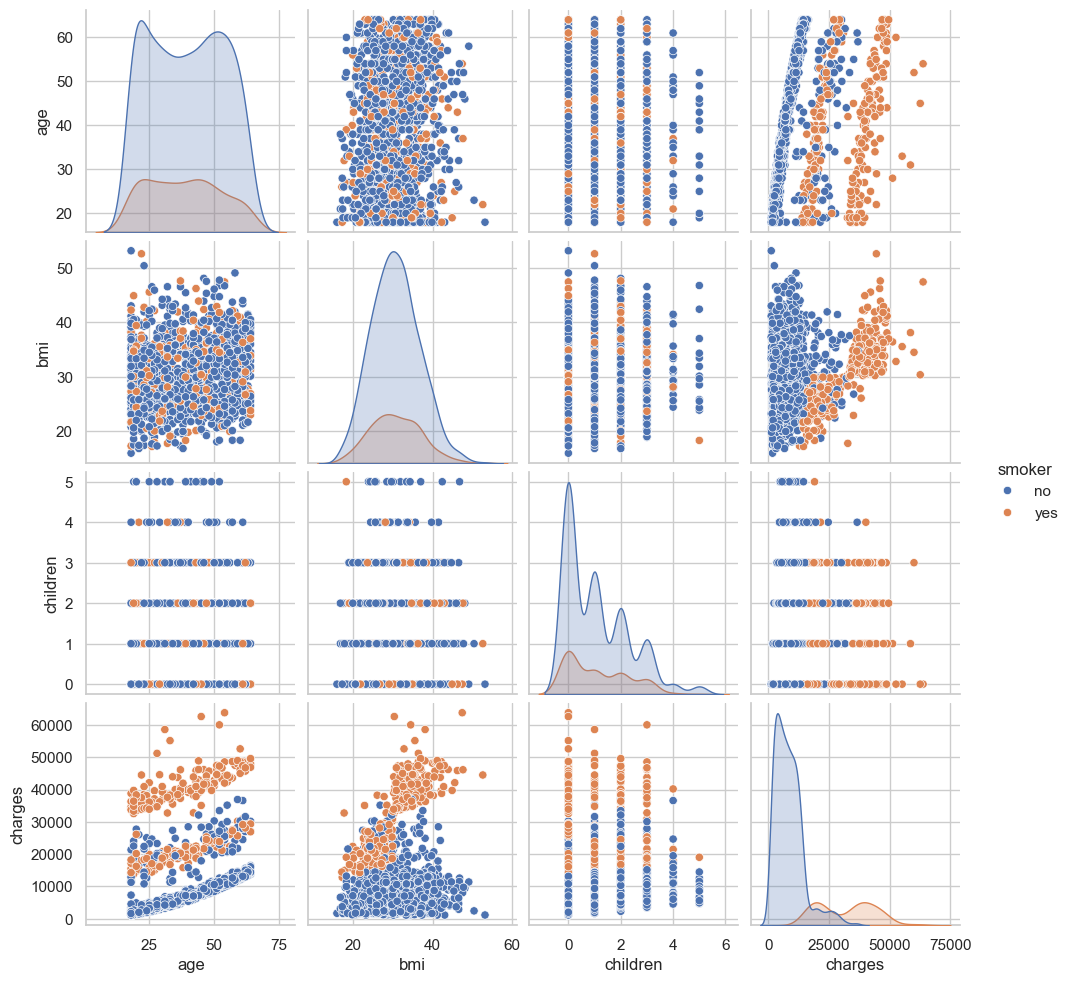

In [137]:
col = numerical_cols + ['charges']
sns.pairplot(df_regresion, hue='smoker', vars=col)

Observando las graficas la variables de `smoker` logra dividir bastante bien las variables númericas frente a `charges` que es nuestra variable a predecir.

### Preprocesamiento

In [138]:
def preprocess_dataset(df, target="charges", test_size=0.2, random_state=42):
    """
    Preprocesamiento:
    
    - Conversión de variables binarias (sex, smoker)
    - One-hot encoding para region
    - Train/test split
    - Creación de dos pipelines:
         (1) con escalado
         (2) sin escalado
    - Transformación de X_train y X_test según cada pipeline
    """

    df = df.copy()

    # ============================================================
    # 1. MAPEO DE VARIABLES BINARIAS
    # ============================================================
    binary_maps = {
        "sex": {"male": 1, "female": 0},
        "smoker": {"yes": 1, "no": 0}
    }

    for col, mapping in binary_maps.items():
        df[col] = df[col].map(mapping)

    # df['age*bmi'] = df['age'] * df['bmi']

    # ============================================================
    # 2. TRAIN/TEST SPLIT
    # ============================================================
    X = df.drop(columns=[target])
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # ============================================================
    # 3. IDENTIFICAR TIPOS DE VARIABLES
    # ============================================================
    numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

    # ============================================================
    # 4. DEFINIR TRANSFORMACIONES
    # ============================================================
    numeric_scaler = Pipeline([
        ("scaler", StandardScaler())
    ])

    categorical_encoder = Pipeline([
        ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
    ])

    # Pipeline CON escalado
    preprocess_scaled = ColumnTransformer([
        ("num", numeric_scaler, numeric_cols),
        ("cat", categorical_encoder, categorical_cols)
    ])

    # Pipeline SIN escalado
    preprocess_noscale = ColumnTransformer([
        ("num", "passthrough", numeric_cols),
        ("cat", categorical_encoder, categorical_cols)
    ])

    # ============================================================
    # 5. AJUSTAR LOS PIPELINES SOLO CON TRAIN
    # ============================================================
    X_train_scaled = preprocess_scaled.fit_transform(X_train)
    X_test_scaled = preprocess_scaled.transform(X_test)

    X_train_noscale = preprocess_noscale.fit_transform(X_train)
    X_test_noscale = preprocess_noscale.transform(X_test)

    # ============================================================
    # 6. OBTENER FEATURE NAMES PARA AMBOS PIPELINES
    # ============================================================
    def get_feature_names(ct):
        names = []
        for name, trans, cols in ct.transformers_:
            if name == "num":
                names.extend(cols)
            elif name == "cat":
                names.extend(trans.get_feature_names_out(cols))
        return names

    features_scaled = get_feature_names(preprocess_scaled)
    features_noscale = get_feature_names(preprocess_noscale)

    # Convertir a DataFrames
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=features_scaled, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=features_scaled, index=X_test.index)

    X_train_noscale = pd.DataFrame(X_train_noscale, columns=features_noscale, index=X_train.index)
    X_test_noscale = pd.DataFrame(X_test_noscale, columns=features_noscale, index=X_test.index)

    # ============================================================
    # 7. DEVOLVER TODOS LOS DATOS
    # ============================================================
    return {
        "X_train_scaled": X_train_scaled,
        "X_test_scaled": X_test_scaled,
        "X_train_noscale": X_train_noscale,
        "X_test_noscale": X_test_noscale,
        "y_train": y_train,
        "y_test": y_test,
        "pipeline_scaled": preprocess_scaled,
        "pipeline_noscale": preprocess_noscale,
        "numeric_cols": numeric_cols,
        "categorical_cols": categorical_cols,
        "features_scaled": features_scaled,
        "features_noscale": features_noscale
    }

A continuación se describen los pasos incluidos en la función de preprocesamiento:

- **Mapeo de variables binarias (sex, smoker):**
Las variables categóricas binarias sex y smoker fueron convertidas a formato numérico mediante un mapeo directo a 0 y 1. Esto permite tratarlas como predictores numéricos sin necesidad de aplicar codificación one-hot y evita la creación de columnas adicionales innecesarias.

- **División del dataset en entrenamiento y prueba:**
Antes de aplicar cualquier transformación, el conjunto de datos se dividió en train y test utilizando un 80/20. Esta separación previa garantiza que los procesos de escalado y codificación se ajusten exclusivamente con datos de entrenamiento, evitando cualquier riesgo de data leakage.

- **Identificación de variables numéricas y categóricas:**
Las columnas correspondientes a valores numéricos y categóricos se detectaron a partir de sus tipos de datos, permitiendo construir transformaciones específicas para cada tipo de predictor.

- **Codificación one-hot para variables nominales (region):**
La variable `region`, al ser categórica nominal sin un orden inherente, se codificó mediante one-hot encoding utilizando drop="first" para evitar multicolinealidad entre las nuevas columnas generadas.


**Construcción de dos pipelines de preprocesamiento:**

Se definieron dos esquemas de transformación:
- Un pipeline con escalado, que aplica StandardScaler a las variables numéricas y está diseñado para modelos sensibles a la escala.
- Un pipeline sin escalado, que solo aplica one-hot encoding a las categóricas, recomendado para modelos basados en árboles que no dependen de la magnitud de los predictores.

Cada pipeline fue ajustado exclusivamente con X_train, preservando así el principio fundamental de evitar fuga de información. Posteriormente, se transformaron tanto el conjunto de entrenamiento como el de prueba.

Tras las transformaciones, se reconstruyeron los nombres de las variables finales para ambos pipelines, facilitando la interpretación y el análisis posterior del modelo.

In [139]:
Preprocesamiento = preprocess_dataset(df_regresion)

### Selección del modelo de regresión

Para este problema de regresión, algunos modelos tienden a funcionar mejor que otros según la naturaleza de las variables y la relación no lineal que existe entre ellas y el costo médico.

Dentro de los modelos que requieren escalado, los modelos lineales regularizados, como **Ridge** y **Lasso**, así como el modelo base **LinearRegression**, ofrecen una buena referencia inicial: capturan tendencias generales y reducen el riesgo de sobreajuste. Sin embargo, debido a que la relación entre las variables (especialmente smoker) y el costo médico presenta cambios bruscos y patrones no lineales, estos algoritmos pueden quedarse cortos al modelar interacciones complejas. El modelo **KNN**, aunque también usa escalado, puede captar relaciones no lineales, pero su desempeño depende fuertemente de la distancia entre puntos y suele verse afectado por ruido.

Por ello, en este tipo de dataset suelen destacar los modelos que no requieren escalado y están basados en árboles, como **Random Forest**, **Gradient Boosting** y **LightGBM**. Estos algoritmos suelen ofrecer el mejor rendimiento porque detectan patrones más complejos, capturan no linealidades de forma natural y manejan mejor las interacciones entre variables. En general, son los candidatos más fuertes para obtener el menor error de predicción en este caso.

### Modelado

In [140]:
# Modelos que requieren escalado
modelos_scaled = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "KNN": KNeighborsRegressor(),
}

# Modelos que NO requieren escalado
modelos_noscale = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42)
}

In [141]:
def evaluar_modelos(modelos, X_train, X_test, y_train, y_test):
    resultados = []

    for nombre, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        pred = modelo.predict(X_test)

        mse = mean_squared_error(y_test, pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, pred)

        resultados.append([nombre, mse, rmse, r2])

    return pd.DataFrame(resultados, columns=["Modelo", "MSE", "RMSE", "R2"]).sort_values("RMSE")


In [142]:
# Evaluar modelos con escalado
result_scaled = evaluar_modelos(
    modelos_scaled,
    Preprocesamiento["X_train_scaled"],
    Preprocesamiento["X_test_scaled"],
    Preprocesamiento["y_train"],
    Preprocesamiento["y_test"]
)

# Evaluar modelos sin escalado
result_noscale = evaluar_modelos(
    modelos_noscale,
    Preprocesamiento["X_train_noscale"],
    Preprocesamiento["X_test_noscale"],
    Preprocesamiento["y_train"],
    Preprocesamiento["y_test"]
)


In [143]:
print("Modelos CON escalado:")
result_scaled

Modelos CON escalado:


,Modelo,MSE,RMSE,R2
0,LinearRegression,3.547802e+07,5956.342894,0.806929
2,Lasso,3.549317e+07,5957.614852,0.806846
1,Ridge,3.566313e+07,5971.861741,0.805921
3,KNN,6.500415e+07,8062.515078,0.646248


In [144]:
print("Modelos SIN escalado:")
result_noscale

Modelos SIN escalado:


,Modelo,MSE,RMSE,R2
1,GradientBoosting,1.821824e+07,4268.283018,0.900856
2,LightGBM,2.072912e+07,4552.924706,0.887192
0,RandomForest,2.211300e+07,4702.446229,0.879661


Vamos a encontrar los mejores hiperparametros para nuestros modelos de arboles.

In [145]:
rf_estimator = RandomForestRegressor(criterion='squared_error',
                                    min_samples_leaf=2,
                                    bootstrap=True,
                                    oob_score=False,
                                    random_state=42,
                                    verbose=0)


param_grid_rf = {
    'max_depth': range(1, 10), #profundidad máxima
    'min_samples_split': range(10, 50, 1), #minimo numero de observaciones por split
    'n_estimators': range(1,10) # número de árboles en el bosque
}

gs_rf = GridSearchCV(
    estimator=rf_estimator,
    param_grid=param_grid_rf,
    scoring='neg_mean_squared_error',
    cv=10
)


gs_rf.fit(Preprocesamiento["X_train_noscale"], Preprocesamiento["y_train"])

print("Mejores hiperparámetros RandomForest:")
print(gs_rf.best_params_)

best_rf = gs_rf.best_estimator_

Mejores hiperparámetros RandomForest:
{'max_depth': 4, 'min_samples_split': 10, 'n_estimators': 8}


In [146]:
lgbm_estimator = LGBMRegressor(
    objective='regression',      
    metric='mse',                
    random_state=42, 
    verbose=-1                  
)

param_grid_lgbm = {
    'n_estimators': [25, 50, 75, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 50],         # Número máximo de hojas (controla la complejidad)
    'max_depth': range(1,10,2)               
}

# 3. Configuración del GridSearchCV
gs_lgbm = GridSearchCV(
    estimator=lgbm_estimator,
    param_grid=param_grid_lgbm,
    scoring='neg_mean_squared_error',   
    cv=10                               
)


gs_lgbm.fit(Preprocesamiento["X_train_noscale"], Preprocesamiento["y_train"])

print("Mejores hiperparámetros LightGBM:")
print(gs_lgbm.best_params_)

best_lgbm = gs_lgbm.best_estimator_

Mejores hiperparámetros LightGBM:
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 20}


In [147]:
gb_estimator = GradientBoostingRegressor(
    random_state=42
)

param_grid_gb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0]
}

gs_gb = GridSearchCV(
    estimator=gb_estimator,
    param_grid=param_grid_gb,
    scoring='neg_mean_squared_error',
    cv=10
)

gs_gb.fit(Preprocesamiento["X_train_noscale"], Preprocesamiento["y_train"])

print("Mejores hiperparámetros Gradient Boosting:")
print(gs_gb.best_params_)

best_gb = gs_gb.best_estimator_

Mejores hiperparámetros Gradient Boosting:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.9}


In [148]:
modelos_noscale_tunned = {
    "RandomForest_tunned": best_rf,
    "GradientBoosting_tunned": best_gb,
    "LightGBM_tunned": best_lgbm
}

result_noscale_tunned = evaluar_modelos(
    modelos_noscale,
    Preprocesamiento["X_train_noscale"],
    Preprocesamiento["X_test_noscale"],
    Preprocesamiento["y_train"],
    Preprocesamiento["y_test"]
)
result_noscale_tunned

,Modelo,MSE,RMSE,R2
1,GradientBoosting,1.821824e+07,4268.283018,0.900856
2,LightGBM,2.072912e+07,4552.924706,0.887192
0,RandomForest,2.211300e+07,4702.446229,0.879661


In [149]:
skf = KFold(n_splits=10, shuffle=True, random_state=42)


for name, model in modelos_noscale_tunned.items():

    pipeline = Pipeline([
            ('preprocesamiento', Preprocesamiento['pipeline_noscale']),
            ('model', model)
        ])

    scores_r2 = cross_val_score(pipeline, X, y, cv=skf, scoring='r2')
    scores_rmse = cross_val_score(pipeline, X, y, cv=skf, scoring='neg_root_mean_squared_error')

    print('Modelo ' + name)

    print(f"  R² scores: {scores_r2}")
    print(f"  Mean R²: {scores_r2.mean():.4f}\n")

    print(f"  RMSE scores: {-1 * scores_rmse}")
    print(f"  Mean RMSE: {-1 * scores_rmse.mean():.4f}\n")



Modelo RandomForest_tunned
  R² scores: [0.8681431  0.86535201 0.86038706 0.84534276 0.93279894 0.85718516
 0.83927943 0.75723125 0.82520313 0.86281617]
  Mean R²: 0.8514

  RMSE scores: [4265.01554847 4819.35007931 4249.76270464 4915.10836457 3481.05749615
 4536.87386478 4327.31123446 5132.94450558 5553.00691226 4322.16924434]
  Mean RMSE: 4560.2600

Modelo GradientBoosting_tunned
  R² scores: [0.87680553 0.88794042 0.86774099 0.84738306 0.93351876 0.86149316
 0.83578638 0.77145121 0.82813076 0.86641787]
  Mean R²: 0.8577

  RMSE scores: [4122.53918353 4396.56020589 4136.32334194 4882.57962555 3462.36363016
 4467.92265954 4374.0826846  4980.34743821 5506.30752206 4265.05350645]
  Mean RMSE: 4459.4080

Modelo LightGBM_tunned
  R² scores: [0.87418745 0.89243681 0.86861414 0.84886144 0.93586027 0.86078063
 0.83566401 0.77451436 0.82882904 0.86783834]
  Mean R²: 0.8588

  RMSE scores: [4166.11432818 4307.45114597 4122.64708159 4858.87361239 3400.84391536
 4479.40015139 4375.71211128 4946.

### Resultados

In [150]:
best_model = best_lgbm

best_model.fit(Preprocesamiento['X_train_noscale'], Preprocesamiento['y_train'])

LGBMRegressor(learning_rate=0.05, max_depth=3, metric='mse', num_leaves=20,
              objective='regression', random_state=42, verbose=-1)

Vamos a ver como fueron la predicciones con el mejor modelo

**TRAIN**

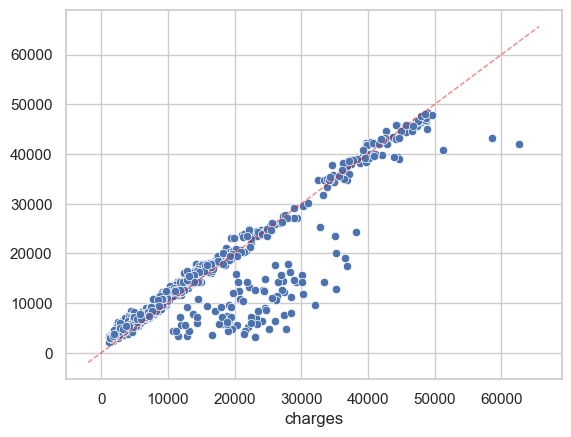

In [151]:
y_pred_train = best_model.predict(Preprocesamiento['X_train_noscale'])

sns.scatterplot(x=Preprocesamiento['y_train'], y=y_pred_train)

min_val = min(plt.xlim()[0], plt.ylim()[0])
max_val = max(plt.xlim()[1], plt.ylim()[1])

line_coords = np.linspace(min_val, max_val, 100)

plt.plot(
    line_coords,
    line_coords,
    color='red',
    linestyle='--',
    linewidth=1,
    alpha=0.5
);

In [152]:
# df_resultados = pd.DataFrame({
#     'Real': Preprocesamiento['y_train'],
#     'Predicho': y_pred_train
# })


# df_resultados['Error_Absoluto'] = np.abs(df_resultados['Real'] - df_resultados['Predicho'])

# df_resultados = df_resultados.sort_values(by='Error_Absoluto', ascending=False)

# indices = df_resultados[df_resultados['Error_Absoluto'] > 10000].index

# df_valors_atipicos = df_regresion.loc[indices]

**TEST**

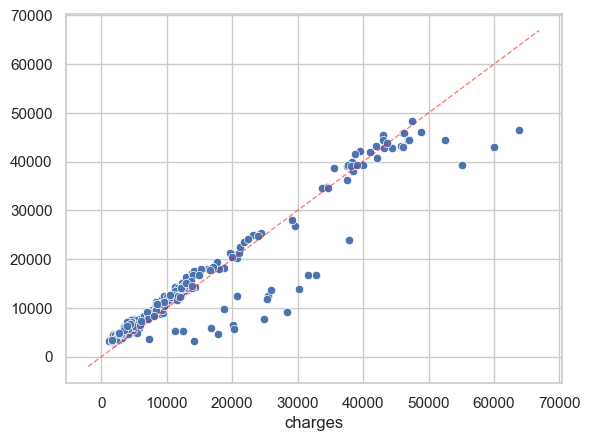

In [153]:
y_pred_test = best_model.predict(Preprocesamiento['X_test_noscale'])

sns.scatterplot(x=Preprocesamiento['y_test'], y=y_pred_test)

min_val = min(plt.xlim()[0], plt.ylim()[0])
max_val = max(plt.xlim()[1], plt.ylim()[1])

line_coords = np.linspace(min_val, max_val, 100)

plt.plot(
    line_coords,
    line_coords,
    color='red',
    linestyle='--',
    linewidth=1,
    alpha=0.5
);

Vamos a ver los scores de ambos y analizar si hay algun tipo de underfitting u overfitting

In [154]:
print(f"R^2 test: {r2_score(Preprocesamiento['y_test'], y_pred_test)}")
print(f"R^2 train: {r2_score(Preprocesamiento['y_train'], y_pred_train)}")

print(f"RMSE test: {root_mean_squared_error(Preprocesamiento['y_test'], y_pred_test)}")
print(f"RMSE train: {root_mean_squared_error(Preprocesamiento['y_train'], y_pred_train)}")

R^2 test: 0.9028560399014669
R^2 train: 0.8677383212138711
RMSE test: 4225.0197340452805
RMSE train: 4255.415857528885


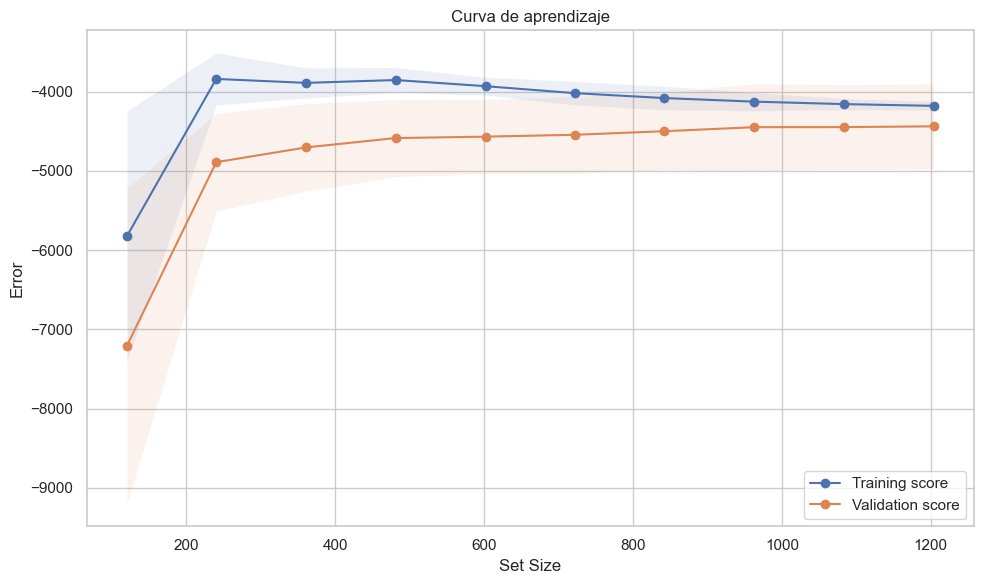

In [155]:
pipeline = Pipeline([
            ('preprocesamiento', Preprocesamiento['pipeline_noscale']),
            ('model', best_lgbm)
        ])

train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipeline,
    X=X,
    y=y,
    cv=skf,
    scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training score')
plt.plot(train_sizes, val_mean, 'o-', label='Validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
plt.title('Curva de aprendizaje')
plt.xlabel('Set Size')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Creacion de los datos sinteticos

In [168]:
df_nuevos = pd.DataFrame({
    'age' : np.random.randint(18, 65, 100),
    'sex' : np.random.choice(["male", "female"], 100),
    'bmi' : np.round(np.random.uniform(15.96, 53.13, 100), 2),
    'children' : np.random.randint(0, 6, 100),
    'smoker' : np.random.choice(["yes","no"], 100),
    'region' : np.random.choice(["northeast", "southeast", "northwest", "southwest"], 100),
})

df_nuevos

,age,sex,bmi,children,smoker,region
0,24,male,22.33,2,no,southeast
1,47,male,50.76,2,no,northeast
2,44,female,38.44,1,no,northeast
3,27,male,19.84,5,yes,northwest
4,18,male,45.37,1,no,northeast
...,...,...,...,...,...,...
95,63,male,51.13,5,no,southeast
96,20,female,49.95,0,yes,southwest
97,43,female,44.66,1,no,southwest
98,54,male,48.67,5,yes,northwest


In [169]:
X_nuevos_t = Preprocesamiento['pipeline_noscale'].transform(df_nuevos)
X_nuevos_t = pd.DataFrame(X_nuevos_t, columns=Preprocesamiento['features_noscale'])

X_nuevos_t

,age,bmi,children,sex_1,smoker_1,region_northwest,region_southeast,region_southwest
0,24.0,22.33,2.0,0.0,0.0,0.0,1.0,0.0
1,47.0,50.76,2.0,0.0,0.0,0.0,0.0,0.0
2,44.0,38.44,1.0,0.0,0.0,0.0,0.0,0.0
3,27.0,19.84,5.0,0.0,0.0,1.0,0.0,0.0
4,18.0,45.37,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
95,63.0,51.13,5.0,0.0,0.0,0.0,1.0,0.0
96,20.0,49.95,0.0,0.0,0.0,0.0,0.0,1.0
97,43.0,44.66,1.0,0.0,0.0,0.0,0.0,1.0
98,54.0,48.67,5.0,0.0,0.0,1.0,0.0,0.0


Ya tenemos los datos, ahora vamos a hacer las predicciones nuevas

In [170]:
predicciones_nuevos = best_model.predict(X_nuevos_t)
df_nuevos["Predicted_charges"] = predicciones_nuevos

In [171]:
df_nuevos.head()

,age,sex,bmi,children,smoker,region,Predicted_charges
0,24,male,22.33,2,no,southeast,7091.394404
1,47,male,50.76,2,no,northeast,10377.877538
2,44,female,38.44,1,no,northeast,9179.389043
3,27,male,19.84,5,yes,northwest,7620.697677
4,18,male,45.37,1,no,northeast,3595.143246


<Axes: xlabel='Predicted_charges', ylabel='Count'>

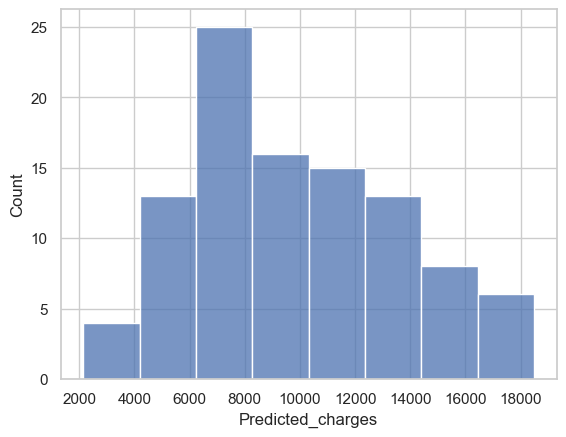

In [176]:
sns.histplot(df_nuevos['Predicted_charges'])

<Axes: xlabel='age', ylabel='Predicted_charges'>

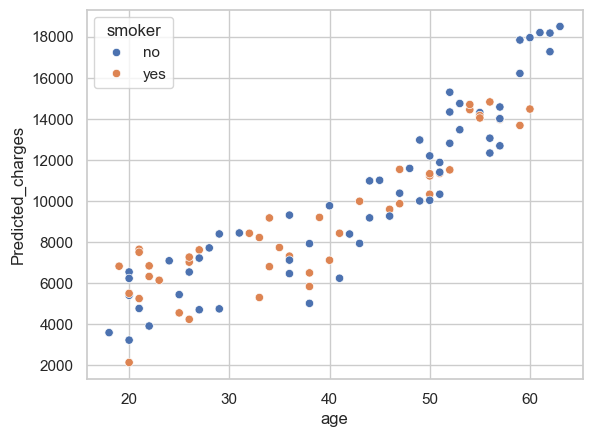

In [175]:
sns.scatterplot(df_nuevos, y='Predicted_charges', x='age', hue='smoker')

<Axes: xlabel='smoker', ylabel='Predicted_charges'>

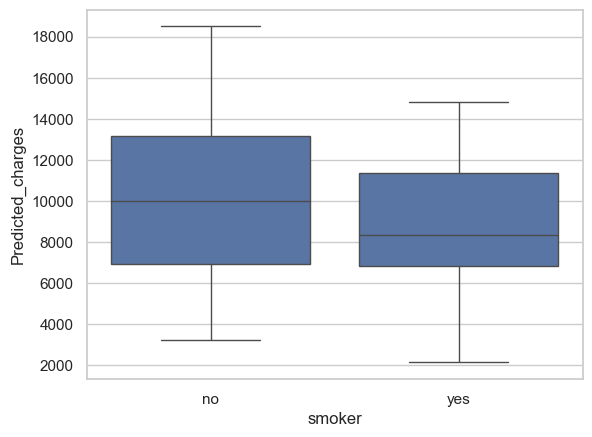

In [174]:
sns.boxplot(x='smoker', y='Predicted_charges',
            data=df_nuevos)

### Conclusiones

Ahorita las pongo